# Non-Monetary Restrictions
## Goal of Notebook:
* Prepare the data for classification
* Create classification(s) models
* Compare accuracy of classification models

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder

import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras

# Prepare the data for classification

* Remove nan data
* create train and test data
* create features and labels

In [ ]:
#select only columns applicable to classifier
use_col = ['Gender', 'Race', 'Ethnicity', 'Age_at_Crime',
            'Age_at_Arrest', 'Court_ORI',
            'Judge_Name', 'Arrest_Type', 'Offense_Date',
            'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
            'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
            'Representation_Type', 'prior_vfo_cnt', 
            'prior_nonvfo_cnt', 'prior_misd_cnt',
            'supervision', 'NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
            'Contact_Pretrial_Service_Agency',
            'Electronic_Monitoring', 'Travel_Restrictions',
            'Passport_Surrender','No_Firearms_or_Weapons',
            'Maintain_Employment', 'Maintain_Housing',
            'Maintain_School', 'Placement_in_Mandatory_Program',
            'Removal_to_Hospital', 'Obey_Order_of_Protection',
            'Obey_Court_Conditions-Family_Offense', 'Other_NMR']
#This is for when we want to make x, y sets
pred_cols = ['NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
             'Contact_Pretrial_Service_Agency',
             'Electronic_Monitoring', 'Travel_Restrictions',
             'Passport_Surrender','No_Firearms_or_Weapons',
             'Maintain_Employment', 'Maintain_Housing',
             'Maintain_School', 'Placement_in_Mandatory_Program',
             'Removal_to_Hospital', 'Obey_Order_of_Protection',
             'Obey_Court_Conditions-Family_Offense', 'Other_NMR']
#Load Data
df = pd.read_pickle("clean_df.pkl")
df = df.filter(use_col)

#Filter rows so we are only looking at 2018 to present years
df = df[pd.DatetimeIndex(df['Offense_Date']).year >= 2018 ].reset_index(drop = True)

#create df where no nan in NMF column
df = df[df['NMR_at_Arraign'].notna()]

In [ ]:
#Tidy the data so that it is complete

#Change nan to 'Unkown' in categorical data
categories_list = ['Gender', 'Race', 'Ethnicity',
                   'Judge_Name', 'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
                   'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
                   'Representation_Type' ]
#In the categorical data change the nan values to 'Unknown'
df[categories_list] = df[categories_list].fillna('Unknown')

#Replace Age_at_Crime and Age_at_Arrest with median
crime_age_median = df['Age_at_Crime'].median()
arrest_age_median = df['Age_at_Arrest'].median()
df['Age_at_Crime'].fillna(crime_age_median, inplace = True)
df['Age_at_Arrest'].fillna(arrest_age_median, inplace = True)

#Replace nan with a random value with correct weighted probability (to match the population)
vfo_choices = [0.0, 1.0, 2.0]
df['prior_vfo_cnt'] = df['prior_vfo_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(vfo_choices, p=[0.84, 0.13, 0.03])))
nonvfo_choices = [0.0, 1.0, 2.0, 3.0, 4.0]
df['prior_nonvfo_cnt'] = df['prior_nonvfo_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(nonvfo_choices, 1, p=[0.74, 0.14, 0.06, 0.03, 0.03])))
misd_choices = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1.0]
df['prior_misd_cnt'] = df['prior_misd_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(misd_choices, 1, p=[0.54, 0.13, 0.08, 0.07, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01])))
supervision_choices = [0.0, 1.0]
df['supervision'] = df['supervision'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(supervision_choices, 1, p=[0.91, 0.09])))

#For NMR_at_Arraign and below change N to 0.0 and Y to 1.0
binary_list = ['Top_Charge_at_Arrest_Violent_Felony_Ind','NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign', 'Contact_Pretrial_Service_Agency',
               'Electronic_Monitoring', 'Travel_Restrictions', 'Passport_Surrender', 'No_Firearms_or_Weapons',
               'Maintain_Employment', 'Maintain_Housing', 'Maintain_School', 'Placement_in_Mandatory_Program',
               'Removal_to_Hospital', 'Obey_Order_of_Protection', 'Obey_Court_Conditions-Family_Offense', 'Other_NMR']

for i in binary_list:
  df[i] = df[i].map({'Y': 1.0 ,'N': 0.0})

#Make the age into age groups for both age at crime and age at arrest
df.loc[df['Age_at_Crime'] <= 17, 'age_group_crime'] = 0
df.loc[df['Age_at_Crime'].between(17,24, inclusive = True), 'age_group_crime'] = 1
df.loc[df['Age_at_Crime'].between(25,34, inclusive = True), 'age_group_crime'] = 2
df.loc[df['Age_at_Crime'].between(35,44, inclusive = True), 'age_group_crime'] = 3
df.loc[df['Age_at_Crime'].between(45,54, inclusive = True), 'age_group_crime'] = 4
df.loc[df['Age_at_Crime'].between(55,64, inclusive = True), 'age_group_crime'] = 5
df.loc[df['Age_at_Crime'] >= 65, 'age_group_crime'] = 6

df.loc[df['Age_at_Arrest'] <= 17, 'age_group_arrest'] = 0
df.loc[df['Age_at_Arrest'].between(17,24, inclusive = True), 'age_group_arrest'] = 1
df.loc[df['Age_at_Arrest'].between(25,34, inclusive = True), 'age_group_arrest'] = 2
df.loc[df['Age_at_Arrest'].between(35,44, inclusive = True), 'age_group_arrest'] = 3
df.loc[df['Age_at_Arrest'].between(45,54, inclusive = True), 'age_group_arrest'] = 4
df.loc[df['Age_at_Arrest'].between(55,64, inclusive = True), 'age_group_arrest'] = 5
df.loc[df['Age_at_Arrest'] >= 65, 'age_group_arrest'] = 6

df['Court_ORI'].unique()
##Remove Letters from Court ORI because they are consistent in each
df['Court_ORI'] = df["Court_ORI"].str.replace("[NYJ]","")
#Convert Court ORI from string to int
df['Court_ORI'] = [int(i) for i in df['Court_ORI']]

#Make arrest type binary 'DAT' = 1, 'Custody' = 0
df['Arrest_Type'] = df['Arrest_Type'].map({'DAT': 1.0 ,'Custody': 0.0})

#For Top Charge Severity at Arrest Change them into integers based on severity
#0- Unknown, 1-Violation, 2-Infraction, 3-Misdemeanor, 4-Felony
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Unknown","0.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Violation","1.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Infraction","2.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Misdemeanor","3.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Felony","4.0")

#For Top Charge Weight at Arrest give integers weights based on severity
#0-Unknown, 1-V, 2-I, 3-UM, 4-BM, 5-AM, 6-EF, 7-DF, 8-CF, 9-BF, 10-AF
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("Unknown", 0.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("V", 1.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("I", 2.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("UM", 3.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("BM", 4.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("AM", 5.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("EF", 6.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("DF", 7.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("CF", 8.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("BF", 9.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("AF", 10.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavou

In [ ]:

#For Top Charge Severity at Arrest Change them into integers based on severity
#0- Unknown, 1-Violation, 2-Infraction, 3-Misdemeanor, 4-Felony
#Mapping was taking long time so used .replace instead
#for i in df['Top_Charge_Severity_at_Arrest']:
  #df['Top_Charge_Severity_at_Arrest'] = df['Top_Charge_Severity_at_Arrest'].map({'Unknown': 0.0 ,'Violation': 1.0,
                                                                                 #'Infraction': 2.0, 'Misdemeanor': 3.0, 'Felony': 4.0})


In [ ]:
df.head()

,Gender,Race,Ethnicity,Age_at_Crime,Age_at_Arrest,Court_ORI,Judge_Name,Arrest_Type,Offense_Date,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision,NMR_at_Arraign,Pretrial_Supervision_at_Arraign,Contact_Pretrial_Service_Agency,Electronic_Monitoring,Travel_Restrictions,Passport_Surrender,No_Firearms_or_Weapons,Maintain_Employment,Maintain_Housing,Maintain_School,Placement_in_Mandatory_Program,Removal_to_Hospital,Obey_Order_of_Protection,Obey_Court_Conditions-Family_Offense,Other_NMR,age_group_crime,age_group_arrest
0,Male,Black,Non Hispanic,38.0,38.0,30033,"Clynes, James G.",1.0,2019-11-01,3.0,5.0,0.0,Assault,Public Defender,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
1,Male,White,Non Hispanic,36.0,36.0,30033,"Thompson, Ann D.",0.0,2020-01-01,3.0,5.0,0.0,Larceny,Legal Aid,0.0,1.0,10.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
2,Male,White,Non Hispanic,23.0,23.0,29013,"McAndrews, David",1.0,2019-12-01,3.0,5.0,0.0,Drug,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,Male,White,Non Hispanic,24.0,24.0,14011,"Johnson-Lee, Barbara R.",1.0,2019-12-01,3.0,5.0,0.0,Drug,Public Defender,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,Male,Unknown,Unknown,36.0,36.0,14011,"Keane, Kevin J.",1.0,2019-12-01,3.0,3.0,0.0,Unlicensed Operation,Public Defender,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278454 entries, 0 to 278453
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   Gender                                   278454 non-null  object        
 1   Race                                     278454 non-null  object        
 2   Ethnicity                                278454 non-null  object        
 3   Age_at_Crime                             278454 non-null  float64       
 4   Age_at_Arrest                            278454 non-null  float64       
 5   Court_ORI                                278454 non-null  int64         
 6   Judge_Name                               278454 non-null  object        
 7   Arrest_Type                              278454 non-null  float64       
 8   Offense_Date                             278454 non-null  datetime64[ns]
 9   Top_Charge_Severity_at_Arr

In [ ]:
df.nunique()

Gender                                       3
Race                                         6
Ethnicity                                    3
Age_at_Crime                                79
Age_at_Arrest                               76
Court_ORI                                   71
Judge_Name                                 671
Arrest_Type                                  2
Offense_Date                                42
Top_Charge_Severity_at_Arrest                5
Top_Charge_Weight_at_Arrest                 11
Top_Charge_at_Arrest_Violent_Felony_Ind      2
Arraign Charge Category                     20
Representation_Type                          9
prior_vfo_cnt                                3
prior_nonvfo_cnt                             5
prior_misd_cnt                              11
supervision                                  2
NMR_at_Arraign                               2
Pretrial_Supervision_at_Arraign              2
Contact_Pretrial_Service_Agency              2
Electronic_Mo

# Analyzing the Dataset for NMR

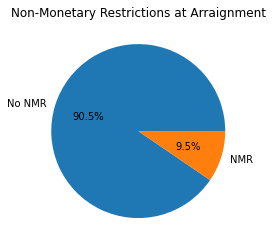

In [ ]:
#Make a pie chart of whether or not NMR is assigned
# Creating plot
df['NMR_at_Arraign'].value_counts()
NMR_counts = [251908, 26546]
labels = ['No NMR', 'NMR']

plt.pie(NMR_counts, labels=labels, autopct="%1.1f%%")
plt.title("Non-Monetary Restrictions at Arraignment")
plt.show()

In [ ]:
#Counts of NMR_at_Arraign by Gender
dfg = df.groupby("Gender")["NMR_at_Arraign"].value_counts(normalize =True)
dfg

Gender   NMR_at_Arraign
Female   0.0               0.927099
         1.0               0.072901
Male     0.0               0.898757
         1.0               0.101243
Unknown  0.0               0.966781
         1.0               0.033219
Name: NMR_at_Arraign, dtype: float64

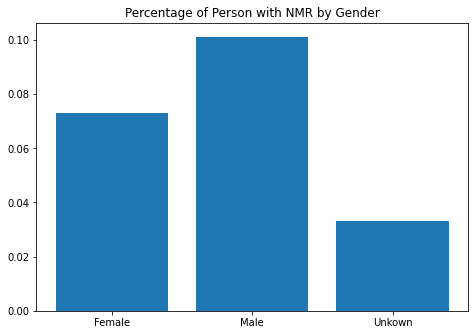

In [ ]:
#Create Plot of Gender Percentage with NMR
Gender = ['Female', 'Male', 'Unkown']
gender_nmr = [ dfg[1], dfg[3], dfg[5]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Gender, gender_nmr)
ax.set_title('Percentage of Person with NMR by Gender')
plt.show()

In [ ]:
#Counts of NMR_at_Arraign by Gender
dfr = df.groupby("Race")["NMR_at_Arraign"].value_counts(normalize =True)
dfr

Race                            NMR_at_Arraign
American Indian/Alaskan Native  0.0               0.938776
                                1.0               0.061224
Asian/Pacific Islander          0.0               0.924658
                                1.0               0.075342
Black                           0.0               0.884408
                                1.0               0.115592
Other                           0.0               0.917208
                                1.0               0.082792
Unknown                         0.0               0.956105
                                1.0               0.043895
White                           0.0               0.897144
                                1.0               0.102856
Name: NMR_at_Arraign, dtype: float64

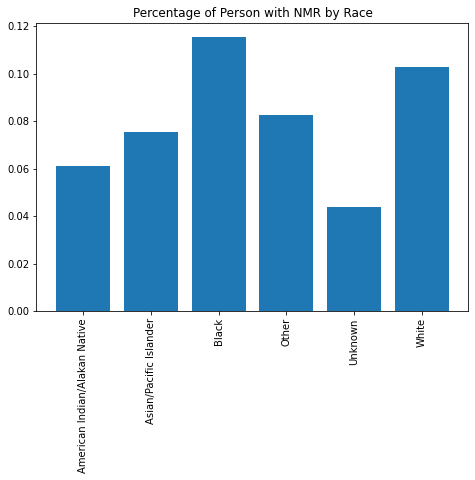

In [ ]:
#Create Plot of Gender Percentage with NMR
Gender = ['American Indian/Alakan Native', 'Asian/Pacific Islander', 'Black', 'Other', 'Unknown', 'White']
gender_nmr = [ dfr[1], dfr[3], dfr[5], dfr[7], dfr[9], dfr[11]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Gender, gender_nmr)
ax.set_title('Percentage of Person with NMR by Race')
plt.xticks(rotation=90)
plt.show()

# Creating Prediction Models for NMR

In [ ]:
#Separate to features and labels
df_clean = df.drop(['Age_at_Crime', 'Age_at_Arrest', 'Offense_Date'], axis = 1)
features = df_clean.drop(pred_cols, axis = 1)
labels = df['NMR_at_Arraign'].copy()

In [ ]:
features.head()

,Gender,Race,Ethnicity,Court_ORI,Judge_Name,Arrest_Type,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision,age_group_crime,age_group_arrest
0,Male,Black,Non Hispanic,30033,"Clynes, James G.",1.0,3.0,5.0,0.0,Assault,Public Defender,0.0,0.0,0.0,0.0,3.0,3.0
1,Male,White,Non Hispanic,30033,"Thompson, Ann D.",0.0,3.0,5.0,0.0,Larceny,Legal Aid,0.0,1.0,10.0,0.0,3.0,3.0
2,Male,White,Non Hispanic,29013,"McAndrews, David",1.0,3.0,5.0,0.0,Drug,Unknown,0.0,0.0,0.0,0.0,1.0,1.0
3,Male,White,Non Hispanic,14011,"Johnson-Lee, Barbara R.",1.0,3.0,5.0,0.0,Drug,Public Defender,0.0,0.0,0.0,0.0,1.0,1.0
4,Male,Unknown,Unknown,14011,"Keane, Kevin J.",1.0,3.0,3.0,0.0,Unlicensed Operation,Public Defender,0.0,0.0,4.0,0.0,3.0,3.0


In [ ]:
features.nunique()

Gender                                       3
Race                                         6
Ethnicity                                    3
Court_ORI                                   71
Judge_Name                                 671
Arrest_Type                                  2
Top_Charge_Severity_at_Arrest                5
Top_Charge_Weight_at_Arrest                 11
Top_Charge_at_Arrest_Violent_Felony_Ind      2
Arraign Charge Category                     20
Representation_Type                          9
prior_vfo_cnt                                3
prior_nonvfo_cnt                             5
prior_misd_cnt                              11
supervision                                  2
age_group_crime                              7
age_group_arrest                             6
dtype: int64

In [ ]:
#Transform Categorical data Numerical 

#For columns with 10 categories or less, OneHotEncode
ohe_categories = ['Gender', 'Race', 'Ethnicity']

features = pd.get_dummies(features, columns = ohe_categories)

In [ ]:
#For columns with too many categories apply leave one out encoder
enc = LeaveOneOutEncoder(cols=['Judge_Name', 'Representation_Type', 'Arraign Charge Category'])
features =  enc.fit_transform(features, labels)
features.head()

#TO DO: ask if they did any sort of feature normalization.

,Court_ORI,Judge_Name,Arrest_Type,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision,age_group_crime,age_group_arrest,Gender_Female,Gender_Male,Gender_Unknown,Race_American Indian/Alaskan Native,Race_Asian/Pacific Islander,Race_Black,Race_Other,Race_Unknown,Race_White,Ethnicity_Hispanic,Ethnicity_Non Hispanic,Ethnicity_Unknown
0,30033,0.150000,1.0,3.0,5.0,0.0,0.092990,0.089994,0.0,0.0,0.0,0.0,3.0,3.0,0,1,0,0,0,1,0,0,0,0,1,0
1,30033,0.141361,0.0,3.0,5.0,0.0,0.111830,0.111493,0.0,1.0,10.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,1,0,1,0
2,29013,0.025061,1.0,3.0,5.0,0.0,0.117247,0.035369,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0,0,0,0,0,0,1,0,1,0
3,14011,0.007955,1.0,3.0,5.0,0.0,0.117247,0.089994,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0,0,0,0,0,0,1,0,1,0
4,14011,0.001621,1.0,3.0,3.0,0.0,0.019769,0.089994,0.0,0.0,4.0,0.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,1


In [ ]:
#Feature Scaling

scaler = StandardScaler()

features_scaled = scaler.fit_transform(features)
features_scaled

array([[-0.34218082,  0.78069711,  1.42340502, ..., -0.51748052,
         0.83606144, -0.50030412],
       [-0.34218082,  0.65732404, -0.70254073, ..., -0.51748052,
         0.83606144, -0.50030412],
       [-0.40776613, -1.00360793,  1.42340502, ..., -0.51748052,
         0.83606144, -0.50030412],
       ...,
       [ 1.71539732,  0.55729376, -0.70254073, ..., -0.51748052,
         0.83606144, -0.50030412],
       [-0.34218082,  0.45254226, -0.70254073, ..., -0.51748052,
         0.83606144, -0.50030412],
       [-0.79227604,  0.17019258, -0.70254073, ..., -0.51748052,
         0.83606144, -0.50030412]])

In [ ]:
feature = pd.DataFrame(features_scaled)
feature.shape

(278454, 26)

### NMR Prediction

In this section of the notebook, we will explore multiple different binary prediction models to predict whether a person will have a NMR condition
Here are the different classifications:
* TO DO: Add a heat map to show correlation
* Logistic Regression
* Naive Bayes
* KNN
* SVM
* TO DO: Try Berta and Neural Networks (Tensor Flow)

In [ ]:
#Make a train and test set
#Note: we have features: no scaling and feature: scaled
#TO DO: check uniformity on test size and random state

X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.3, random_state=3)
X_Train, X_Test, y_Train, y_Test = train_test_split(features, labels, test_size=0.3, random_state=3)

# Logistic Regression

In [ ]:
%%time
#Make a train and test set
LogReg = GridSearchCV(LogisticRegressionCV(random_state = 3, class_weight = 'balanced'), 
                      {'max_iter': [100, 500, 1000]} ,cv = 5)

LogReg.fit(X_train, y_train)

print("Best parameters", LogReg.best_params_)

#Predict the response for the test set
y_pred = LogReg.predict(X_test)
#Find the accuracy, precision, and recall
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Logistic Regression Precision:", metrics.precision_score(y_test, y_pred))
print("Logistic Regression Recall:", metrics.recall_score(y_test, y_pred))



Best parameters {'max_iter': 100}
Logistic Regression Accuracy: 0.710116475334283
Logistic Regression Precision: 0.21052256616677947
Logistic Regression Recall: 0.7421825944995605
CPU times: user 6min 1s, sys: 2min 54s, total: 8min 56s
Wall time: 4min 37s


[[53411 22163]
 [ 2053  5910]]
              precision    recall  f1-score   support

         0.0       0.71      0.96      0.82     55464
         1.0       0.74      0.21      0.33     28073

    accuracy                           0.71     83537
   macro avg       0.72      0.59      0.57     83537
weighted avg       0.72      0.71      0.65     83537



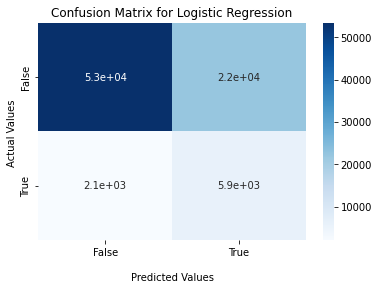

In [ ]:

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_pred, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Logistic Regression');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


# Naives Bayes

In [ ]:
%%time
#Create the NB classifier
#NBclassifier = GaussianNB()

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
NBclassifier = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
NBclassifier.fit(X_train, y_train)

nb_predictions = NBclassifier.predict(X_test)

#Find the accuracy, precision, and recall
print("Naives Bayes Accuracy:", metrics.accuracy_score(y_test, nb_predictions))
print("Naives Bayes Precision:", metrics.precision_score(y_test, nb_predictions))
print("Naives Bayes Recall:", metrics.recall_score(y_test, nb_predictions))


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Naives Bayes Accuracy: 0.8356895746794833
Naives Bayes Precision: 0.21857603281570465
Naives Bayes Recall: 0.2810498555820671
CPU times: user 9.38 s, sys: 2.08 s, total: 11.5 s
Wall time: 2min 27s


[[67573  8001]
 [ 5725  2238]]
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91     73298
         1.0       0.28      0.22      0.25     10239

    accuracy                           0.84     83537
   macro avg       0.59      0.57      0.58     83537
weighted avg       0.82      0.84      0.83     83537



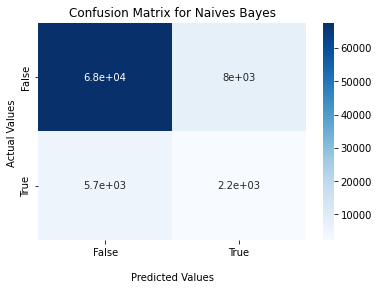

In [ ]:

cm = metrics.confusion_matrix(y_test, nb_predictions)
print(cm)
print(classification_report(nb_predictions, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Naives Bayes');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# k-nearest neighbor

In [ ]:
%%time
#KNN
knn_classifier = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)

#Find the accuracy, precision, and recall
print("KNN Accuracy:", metrics.accuracy_score(y_test, knn_predictions))
print("KNN Precision:", metrics.precision_score(y_test, knn_predictions))
print("KNN Recall:", metrics.recall_score(y_test, knn_predictions))

KNN Accuracy: 0.895267965093312
KNN Precision: 0.36677966101694914
KNN Recall: 0.135878437774708
CPU times: user 14min 15s, sys: 24 s, total: 14min 39s
Wall time: 11min 47s


[[73706  1868]
 [ 6881  1082]]
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     80587
         1.0       0.14      0.37      0.20      2950

    accuracy                           0.90     83537
   macro avg       0.56      0.64      0.57     83537
weighted avg       0.95      0.90      0.92     83537



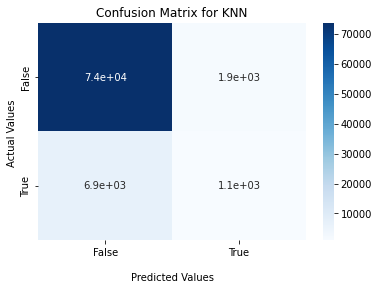

In [ ]:

cm = metrics.confusion_matrix(y_test, knn_predictions)
print(cm)
print(classification_report(knn_predictions, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for KNN');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# SVM
<https://scikit-learn.org/stable/modules/svm.html>

In [ ]:
%%time
#SVM 
svm_classifier = svm.SVC(kernal = 'Linear')
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

#Find the accuracy, precision, and recall
print("svm Accuracy:", metrics.accuracy_score(y_test, svm_predictions))
print("svm Precision:", metrics.precision_score(y_test, svm_predictions))
print("svm Recall:", metrics.recall_score(y_test, svm_predictions))


NameError: ignored

#Random Forest

In [ ]:
%%time
rf_clf = RandomForestClassifier(n_estimators=100, max_depth = 2, random_state= 3, class_weight= 'balanced')

#Train the model using the training sets
rf_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

#Find the accuracy, precision, and recall
print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision:", metrics.precision_score(y_test, y_pred_rf))
print("Random Forest Recall:", metrics.recall_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.6426014819780457
Random Forest Precision: 0.19266080804110397
Random Forest Recall: 0.8617355268115032
CPU times: user 5.35 s, sys: 1.43 s, total: 6.79 s
Wall time: 6.75 s


[[46819 28755]
 [ 1101  6862]]
              precision    recall  f1-score   support

         0.0       0.62      0.98      0.76     47920
         1.0       0.86      0.19      0.31     35617

    accuracy                           0.64     83537
   macro avg       0.74      0.58      0.54     83537
weighted avg       0.72      0.64      0.57     83537



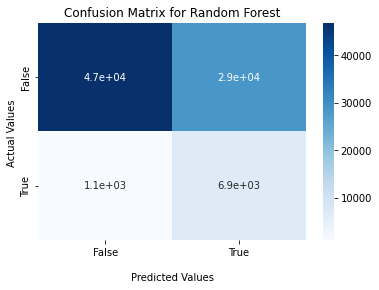

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_rf)
print(cm)
print(classification_report(y_pred_rf, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Random Forest');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Decision Trees

In [ ]:
%%time

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_dt = dt_clf.predict(X_test)

#Find the accuracy, precision, and recall
print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred_dt))
print("Random Forest Precision:", metrics.precision_score(y_test, y_pred_dt))
print("Random Forest Recall:", metrics.recall_score(y_test, y_pred_dt))

Random Forest Accuracy: 0.9997366436429367
Random Forest Precision: 0.998869204673954
Random Forest Recall: 0.9983674494537235
CPU times: user 1.04 s, sys: 10.5 ms, total: 1.05 s
Wall time: 1.2 s


[[75565     9]
 [   13  7950]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     75578
         1.0       1.00      1.00      1.00      7959

    accuracy                           1.00     83537
   macro avg       1.00      1.00      1.00     83537
weighted avg       1.00      1.00      1.00     83537



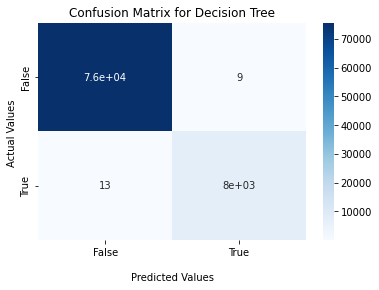

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_dt)
print(cm)
print(classification_report(y_pred_dt, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Decision Tree');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Neural Network
<https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/>

In [ ]:
%%time
nn_model = keras.Sequential([
                             keras.layers.Flatten(input_shape=(26,)),
                             keras.layers.Dense(16, activation=tf.nn.relu),
                             keras.layers.Dense(16, activation=tf.nn.relu),
                             keras.layers.Dense(1, activation=tf.nn.sigmoid),
                             ])

nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

nn_model.fit(X_train, y_train, epochs=10, batch_size=1)

test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
194917/194917 [==============================] - 347s 2ms/step - loss: 0.2616 - accuracy: 0.9048
Epoch 2/10
194917/194917 [==============================] - 337s 2ms/step - loss: 0.2587 - accuracy: 0.9051
Epoch 3/10
194917/194917 [==============================] - 335s 2ms/step - loss: 0.2578 - accuracy: 0.9053
Epoch 4/10
194917/194917 [==============================] - 335s 2ms/step - loss: 0.2588 - accuracy: 0.9054
Epoch 5/10
194917/194917 [==============================] - 334s 2ms/step - loss: 0.2586 - accuracy: 0.9052
Epoch 6/10
194917/194917 [==============================] - 339s 2ms/step - loss: 0.2584 - accuracy: 0.9050
Epoch 7/10
194917/194917 [==============================] - 339s 2ms/step - loss: 0.2579 - accuracy: 0.9053
Epoch 8/10
194917/194917 [==============================] - 334s 2ms/step - loss: 0.2576 - accuracy: 0.9052
Epoch 9/10
194917/194917 [==============================] - 337s 2ms/step - loss: 0.2576 - accuracy: 0.9053
Epoch 10/10
2611/2611 [=====